#Import Data

For the dataset, need to included the kaggle.json in the submitted file into this runtime to access the dataset and download.

In [7]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d budincsevity/szeged-weather

szeged-weather.zip: Skipping, found more recently modified local copy (use --force to force download)


Import the library we want to use

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import time
import zipfile

from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

Unzip the dataset and assign it into a variable to have further process

In [9]:
with zipfile.ZipFile("szeged-weather.zip", "r") as zip_ref:
    zip_ref.extractall("data")

dt = pd.read_csv("data/weatherHistory.csv")

In [10]:
dt.head(5)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


# Data Cleaning and Preprocessing

In [11]:
# change the columns name of the dataframe, replace the space with underline to make it easier to have further process.
dt.rename(columns = {col:col.replace(' ','_') for col in dt.columns},inplace = True)
print(dt.columns)

Index(['Formatted_Date', 'Summary', 'Precip_Type', 'Temperature_(C)',
       'Apparent_Temperature_(C)', 'Humidity', 'Wind_Speed_(km/h)',
       'Wind_Bearing_(degrees)', 'Visibility_(km)', 'Loud_Cover',
       'Pressure_(millibars)', 'Daily_Summary'],
      dtype='object')


In [12]:
# Generate dataset info
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted_Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip_Type               95936 non-null  object 
 3   Temperature_(C)           96453 non-null  float64
 4   Apparent_Temperature_(C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind_Speed_(km/h)         96453 non-null  float64
 7   Wind_Bearing_(degrees)    96453 non-null  float64
 8   Visibility_(km)           96453 non-null  float64
 9   Loud_Cover                96453 non-null  float64
 10  Pressure_(millibars)      96453 non-null  float64
 11  Daily_Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


The output above show all the collumns non-null row count and the data type. We can know thata the Formatted_Date, Summary, Precip_Type and Daily_Summary columns are object data type. And the rest of the columns are float datatype.

In [13]:
# Generate descriptive statistics that summarize the central tendency, dispersion, and shape of a dataset's distribution.
dt.describe()

,Temperature_(C),Apparent_Temperature_(C),Humidity,Wind_Speed_(km/h),Wind_Bearing_(degrees),Visibility_(km),Loud_Cover,Pressure_(millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [14]:
# generate descriptive statistics for columns containing object (categorical) data
dt.describe(include = 'O')

,Formatted_Date,Summary,Precip_Type,Daily_Summary
count,96453,96453,95936,96453
unique,96429,27,2,214
top,2010-08-02 00:00:00.000 +0200,Partly Cloudy,rain,Mostly cloudy throughout the day.
freq,2,31733,85224,20085


In the dt.describe() generated table, we found that the Lood_Cover seen like consistently showing values 0, lets take a look in loud_Cover columns.

In [15]:
columns_to_check = ['Loud_Cover']

# Iterate over each column
for column in columns_to_check:
    unique_values = dt[column].unique()
    print(f"Column '{column}' contains the following unique values: {unique_values}")

Column 'Loud_Cover' contains the following unique values: [0.]


We found that Loud_Cover Columns consistently contains only 0, quite redundant for us, so we decide to drop the columns to reduce the dataset size.

In [16]:
# Drop the Loud_Cover Columns
dt.drop(columns_to_check, axis=1, inplace=True)
dt.head()

,Formatted_Date,Summary,Precip_Type,Temperature_(C),Apparent_Temperature_(C),Humidity,Wind_Speed_(km/h),Wind_Bearing_(degrees),Visibility_(km),Pressure_(millibars),Daily_Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.


Select the weather data from 2006 to 2009 to reduce the model runtime.
Seperate the Formatted_Date to Year, Month, Day, and Hours to process the data easier.

In [17]:
# Convert the Formatted_Date Columns datatype to Datetime.
dt['Formatted_Date']=pd.to_datetime(dt['Formatted_Date'],format='%Y-%m-%d %H:%M:%S.%f',utc=True)

# Seperate tht Formatted_Date columns to Year, Month, Day, and Hours Column
dt['Year'] = dt['Formatted_Date'].dt.year
dt['Month'] = dt['Formatted_Date'].dt.month
dt['Day'] = dt['Formatted_Date'].dt.dayofyear
dt['Hour'] = dt['Formatted_Date'].dt.hour

#Drop the Formatted_Date Columns
column_name = 'Formatted_Date'
dt.drop(column_name, axis=1, inplace=True)

# Filter the data for the years 2006 to 2009 using the 'Formatted_Date' column
weather_data = dt[(dt['Year'] >= 2006) & (dt['Year'] <= 2009)]


# show the first few rows of the filtered data
weather_data.head()

,Summary,Precip_Type,Temperature_(C),Apparent_Temperature_(C),Humidity,Wind_Speed_(km/h),Wind_Bearing_(degrees),Visibility_(km),Pressure_(millibars),Daily_Summary,Year,Month,Day,Hour
0,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.,2006,3,90,22
1,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.,2006,3,90,23
2,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.,2006,4,91,0
3,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.,2006,4,91,1
4,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.,2006,4,91,2


Double check the filtered dataset details.

In [18]:
unique_years = weather_data['Year'].unique()

# Check if all unique years are within the range 2006 to 2009
if all(year in range(2006, 2010) for year in unique_years):
    print("All values in the 'Formatted_Date' column are from the years 2006 to 2009.")
else:
    print("Values in the 'Formatted_Date' column are not exclusively from the years 2006 to 2009.")

# show the filtered_data row and columns count.
weather_data.shape

All values in the 'Formatted_Date' column are from the years 2006 to 2009.


(35064, 14)

Check the dataset contain null values or not.

In [19]:
# check if the weather_data values is null

total =weather_data.isnull().sum().sort_values(ascending = False)
percent =(weather_data.isnull().sum()/len(weather_data)).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data

,Total,Percent
Summary,0,0.0
Precip_Type,0,0.0
Temperature_(C),0,0.0
Apparent_Temperature_(C),0,0.0
Humidity,0,0.0
Wind_Speed_(km/h),0,0.0
Wind_Bearing_(degrees),0,0.0
Visibility_(km),0,0.0
Pressure_(millibars),0,0.0
Daily_Summary,0,0.0


the Filtered data didnt cntain any null values, so we no need to process the null rows.



---



# Data Analysis

##**determine the tempurature, humidity and wind speed distribution in the dataset.**

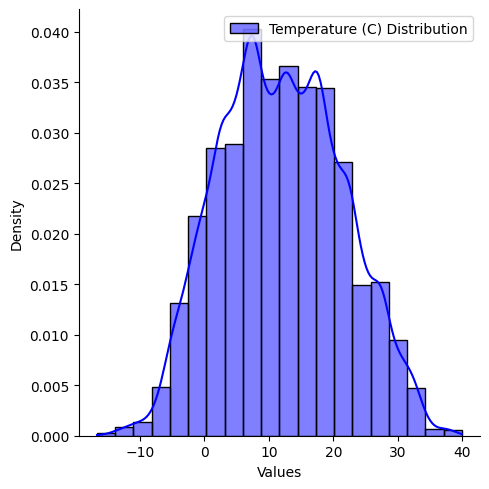

In [ ]:
sns.displot(data=weather_data, x=weather_data["Temperature_(C)"], kde=True, color='b', label='Temperature (C) Distribution', bins = 20, stat="density")

plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()

In [13]:
# Filter the DataFrame where temperature is between 5°C and 20°C
temperature_within_range = weather_data[(weather_data['Temperature_(C)'] >= 5) & (weather_data['Temperature_(C)'] <= 25)]

# Calculate the percentage
percentage_within_range = (len(temperature_within_range) / len(weather_data)) * 100

print(f"The percentage of rows where the temperature is within 5°C to 20°C is: {percentage_within_range:.2f}%")

The percentage of rows where the temperature is within 5°C to 20°C is: 65.44%


The above graph show the temperature is normal distribution in this dataset, most of temperature in Szeged within 4 years are within 5°C to 20°C, which is 65%.



---



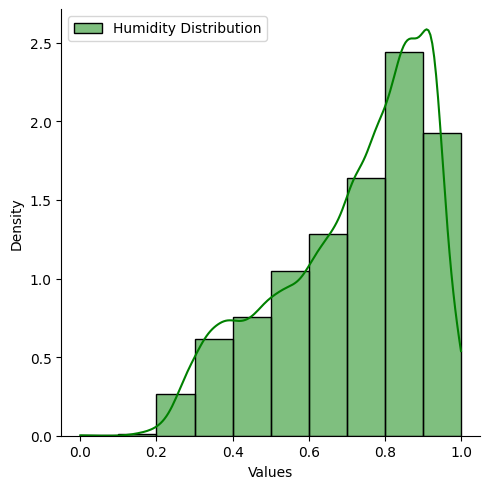

In [ ]:
sns.displot(data=weather_data, x=weather_data["Humidity"], kde=True, color='g', label='Humidity Distribution', bins = 10, stat="density" )

plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()

In [ ]:
# Count percentage when Humidity => 0.7
weather_data[weather_data.Humidity > 0.7]['Humidity'].value_counts().sum()/weather_data.shape[0]

0.6008156513803331

The graph showed that the Humidity is positively skewed distribution, within 4 years in Szeged, there are 60% the humidity is above 0.7, which present Szeged is generally quite humid.



---



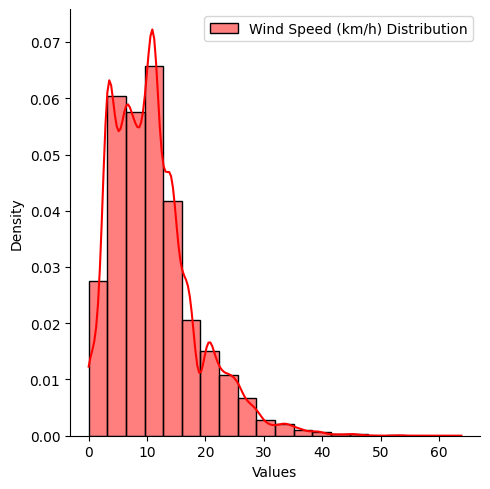

In [ ]:
sns.displot(data=weather_data, x=weather_data["Wind_Speed_(km/h)"], kde=True, color='r', label='Wind Speed (km/h) Distribution', bins = 20, stat="density")

plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()

In [ ]:
# Count the precentage when Wind Speed within 5 to 15 km/h
weather_data[weather_data['Wind_Speed_(km/h)'].between(5,15)]['Wind_Speed_(km/h)'].value_counts().sum()/weather_data.shape[0]

0.5620579511749942

The graph showed that the Wind Speed is skewed distribution, there have 56% of the days within 4 years wind speed are in 5 to 15 km per hour.



---

---





##**find what is the top 10 weather within 4 years in the dataset**






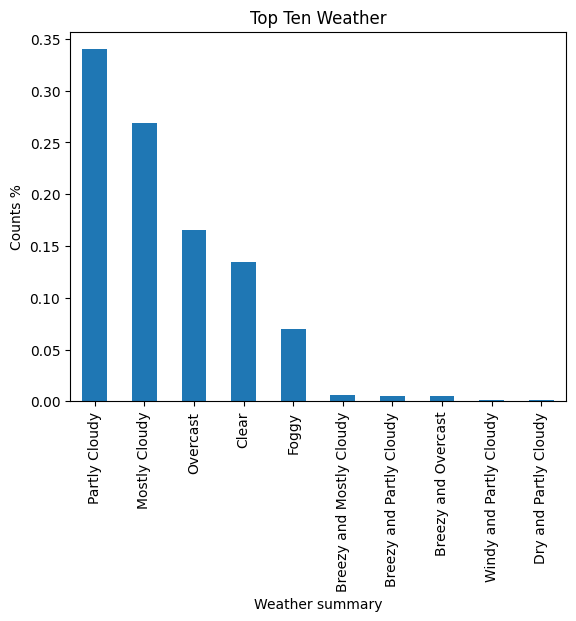

In [15]:
ax = (weather_data['Summary'].value_counts(normalize = True)).head(10).plot(kind = 'bar', title = 'Top Ten Weather' )
ax.set_xlabel("Weather summary")
ax.set_ylabel('Counts %')

plt.show()

The above graph showed that Top 2 weather withn 4 years in Szeged is party coundly and mostly Cloudy.
Let find out the precentage of this 2 weathers in the whole dataset.

In [ ]:
weather_data['Summary'].value_counts().head(2).sum()/ len(weather_data)

0.6084302988820443

The result showed that the in Sezged within 4 years,  almost 61% of the weather are partly cloudy and mostly cloudy



---



In [ ]:
# show the top 10 weather precentage
weather_data.Summary.value_counts(normalize =True).head(10)

Partly Cloudy               0.339893
Mostly Cloudy               0.268538
Overcast                    0.165811
Clear                       0.134896
Foggy                       0.069387
Breezy and Mostly Cloudy    0.006189
Breezy and Partly Cloudy    0.005276
Breezy and Overcast         0.005162
Windy and Partly Cloudy     0.001112
Dry and Partly Cloudy       0.000884
Name: Summary, dtype: float64

In the above output, we can see the those below weather are extremely less in the dataset, we will add the top five weather which is Partly Cloudy, Mostly Cloudy, Overcast, Clear and Foggy to see the precentage.

In [ ]:
# Cpunt the top 5 weather precentage
weather_data.Summary.value_counts(normalize =True).head(5).sum()

0.9785249828884326

The result showed the top 5 weather precentage is almost 98%. which mean in Sezged, 5 of the weather are most common weather, Foggy weather may not have really much.



---



In later further data analysis, we will just only take the top 5 weather since those 5 weathers is already contain 98% of the dataset, and the rest of the weather are lesser than 1%.

In [16]:
# Take only when the data contain the top 5 weathers and assign into new variable.
DAdata = weather_data.loc[(weather_data.Summary == 'Partly Cloudy') | (weather_data.Summary == 'Mostly Cloudy') | (weather_data.Summary == 'Overcast') | (weather_data.Summary == 'Clear') | (weather_data.Summary == 'Clear') | (weather_data.Summary == 'Foggy'), ['Summary', 'Temperature_(C)',
       'Apparent_Temperature_(C)', 'Humidity', 'Wind_Speed_(km/h)',
       'Wind_Bearing_(degrees)', 'Visibility_(km)',
       'Pressure_(millibars)','Month','Year']]
DAdata.head()

,Summary,Temperature_(C),Apparent_Temperature_(C),Humidity,Wind_Speed_(km/h),Wind_Bearing_(degrees),Visibility_(km),Pressure_(millibars),Month,Year
0,Partly Cloudy,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,3,2006
1,Partly Cloudy,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,3,2006
2,Mostly Cloudy,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,4,2006
3,Partly Cloudy,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,4,2006
4,Mostly Cloudy,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,4,2006




---



## **Explore the relationship between temperature and sunmmary**

First, we want to know the relationship between weather summary and temperature.

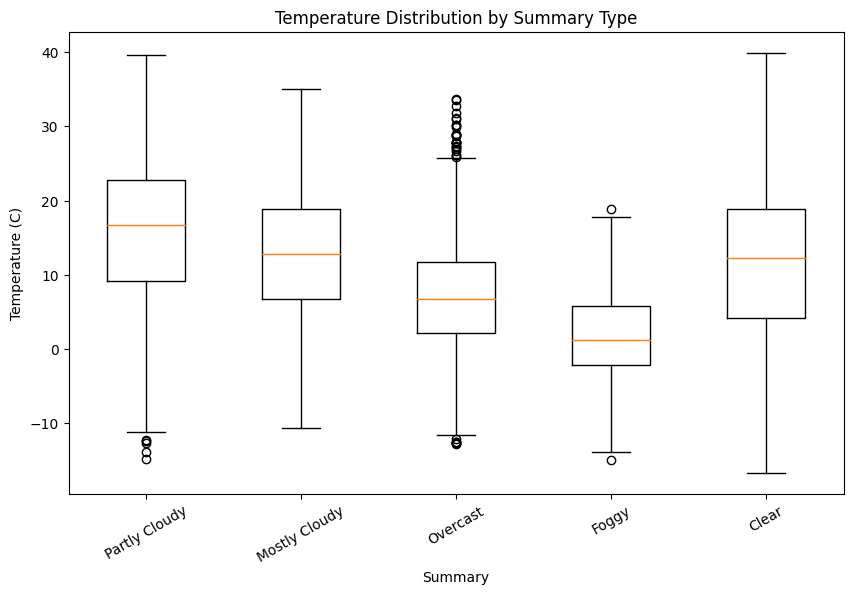

Mean Temperature by Summary:
         Summary  Temperature_(C)
0          Clear        11.864549
1          Foggy         1.697155
2  Mostly Cloudy        12.713728
3       Overcast         6.955644
4  Partly Cloudy        15.924237


In [ ]:
# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot([DAdata[DAdata['Summary'] == summary]['Temperature_(C)'] for summary in DAdata['Summary'].unique()],
            labels=DAdata['Summary'].unique())

# Add labels and title
plt.xlabel('Summary')
plt.ylabel('Temperature (C)')
plt.title('Temperature Distribution by Summary Type')

# Show the plot
plt.xticks(rotation=30)  # Rotate x-axis labels for better visibility
#plt.grid(True)
plt.show()

# Calculate the mean temperature for each summary type
mean_temp_by_summary = DAdata.groupby('Summary')['Temperature_(C)'].mean().reset_index()

# Create a table to summarize the mean temperature by summary
print("Mean Temperature by Summary:")
print(mean_temp_by_summary)

so we can see that the weather distribution and the mean temeperature. the table above show that the mean temperature of Foggy is the lowest, only 1.69c The highest mean temeperature is Partly Cloudy which is 15.92c.



---



We will show each of the weather graph to have more understanding of relationship between weather summary and temperature.

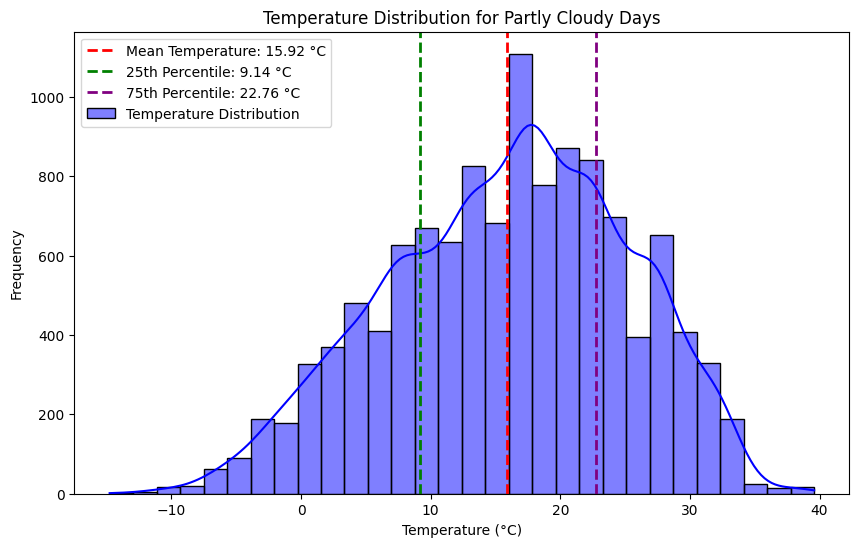


Summary Table for Partly Cloudy:
                  Statistic      Value
0  Minimum Temperature (°C) -15.000000
1  Maximum Temperature (°C)  18.888889
2      25th Percentile (°C)   9.143056
3      75th Percentile (°C)  22.755556



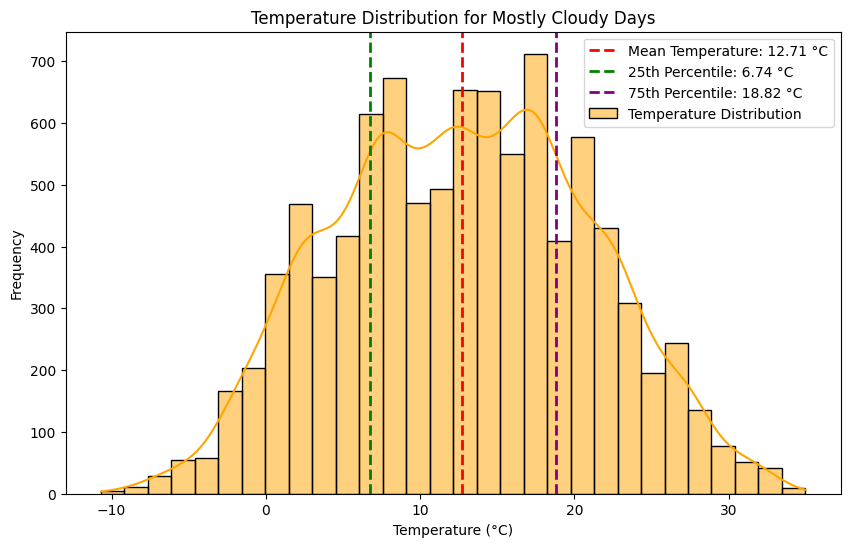


Summary Table for Mostly Cloudy:
                  Statistic      Value
0  Minimum Temperature (°C) -15.000000
1  Maximum Temperature (°C)  18.888889
2      25th Percentile (°C)   6.743056
3      75th Percentile (°C)  18.816667



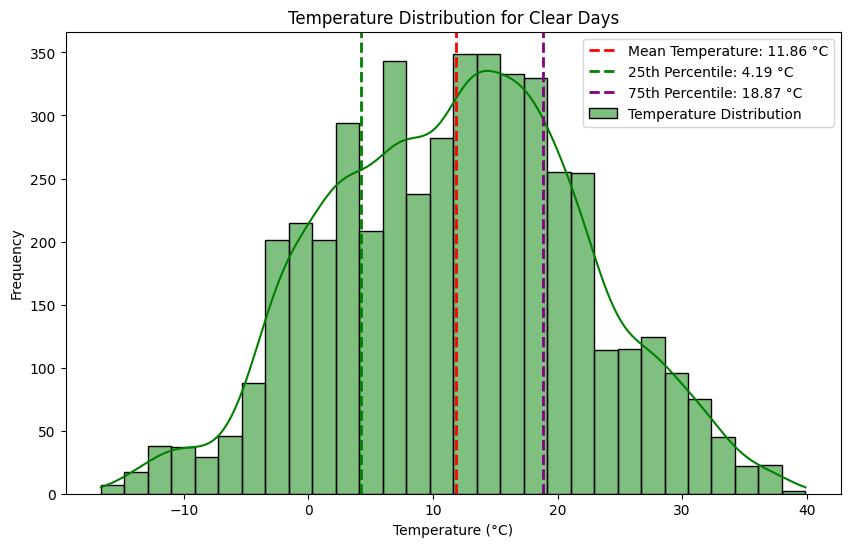


Summary Table for Clear:
                  Statistic      Value
0  Minimum Temperature (°C) -15.000000
1  Maximum Temperature (°C)  18.888889
2      25th Percentile (°C)   4.191667
3      75th Percentile (°C)  18.866667



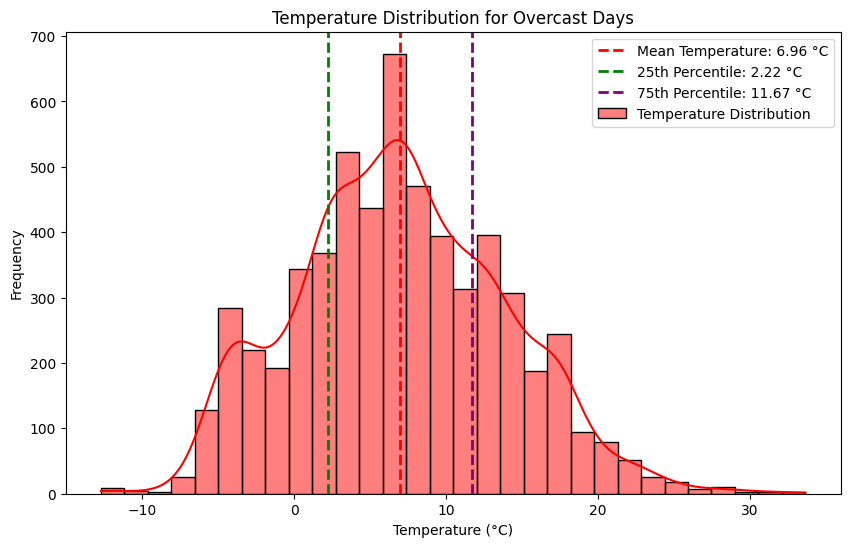


Summary Table for Overcast:
                  Statistic      Value
0  Minimum Temperature (°C) -15.000000
1  Maximum Temperature (°C)  18.888889
2      25th Percentile (°C)   2.222222
3      75th Percentile (°C)  11.666667



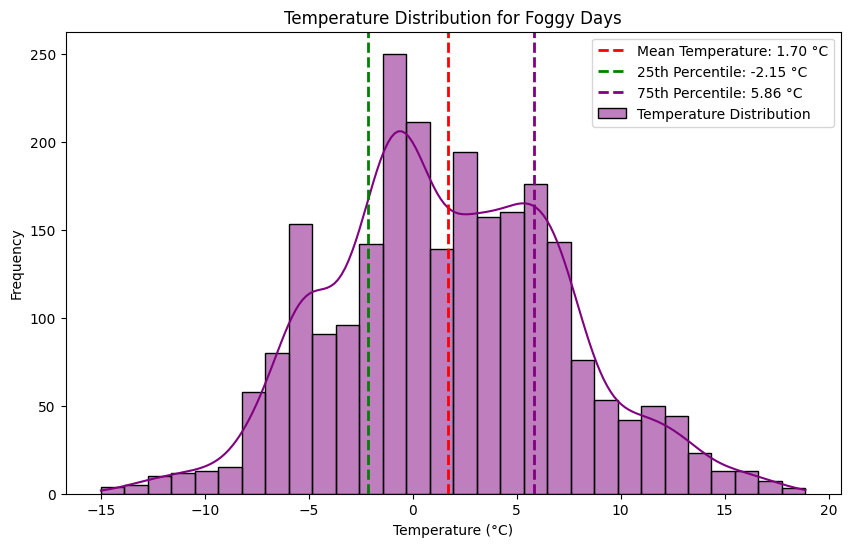


Summary Table for Foggy:
                  Statistic      Value
0  Minimum Temperature (°C) -15.000000
1  Maximum Temperature (°C)  18.888889
2      25th Percentile (°C)  -2.150000
3      75th Percentile (°C)   5.855556



In [19]:
# Dictionary mapping each summary type to a color
summary_types = {
    'Partly Cloudy': 'blue',
    'Mostly Cloudy': 'orange',
    'Clear': 'green',
    'Overcast': 'red',
    'Foggy': 'purple'
}

# Iterate through each summary type
for summary_type in summary_types:
    # Filter data for the current summary type
    summary_data = DAdata[DAdata['Summary'] == summary_type]

    # Plot histogram with line
    plt.figure(figsize=(10, 6))
    sns.histplot(summary_data['Temperature_(C)'], bins=30, kde=True, color=summary_types[summary_type], label='Temperature Distribution')

    # Plot mean temperature line
    mean_temp = summary_data['Temperature_(C)'].mean()
    plt.axvline(mean_temp, color='red', linestyle='--', linewidth=2, label=f'Mean Temperature: {mean_temp:.2f} °C')

    # Calculate 25th and 75th percentiles
    percentile_25 = np.percentile(summary_data['Temperature_(C)'], 25)
    percentile_75 = np.percentile(summary_data['Temperature_(C)'], 75)

    # Plot 25th and 75th percentiles
    plt.axvline(percentile_25, color='green', linestyle='--', linewidth=2, label=f'25th Percentile: {percentile_25:.2f} °C')
    plt.axvline(percentile_75, color='purple', linestyle='--', linewidth=2, label=f'75th Percentile: {percentile_75:.2f} °C')

    # Add labels and title
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    plt.title(f'Temperature Distribution for {summary_type} Days')

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

    # Create summary table
    summary_table = pd.DataFrame({
        'Statistic': ['Minimum Temperature (°C)', 'Maximum Temperature (°C)', '25th Percentile (°C)', '75th Percentile (°C)'],
        'Value': [min_temp, max_temp, percentile_25, percentile_75]
    })

    # Print the summary table
    print(f"\nSummary Table for {summary_type}:\n{summary_table}\n{'='*50}\n")



---



## Explore the relationship between Temperature and Month in Szeged

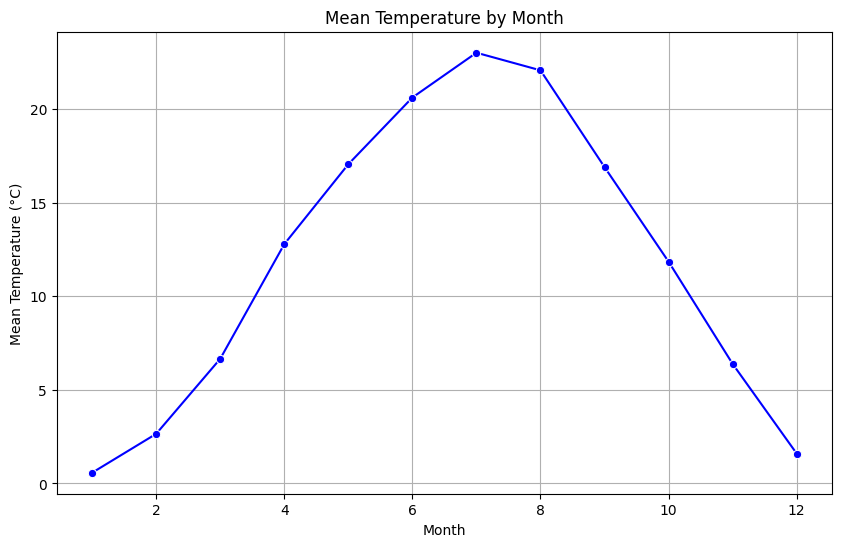

In [ ]:
# Group data by month and calculate the mean temperature for each month
monthly_mean_temp = DAdata.groupby('Month')['Temperature_(C)'].mean().reset_index()

# Plot the relationship between temperature and month
plt.figure(figsize=(10, 6))
sns.lineplot(x='Month', y='Temperature_(C)', data=monthly_mean_temp, marker='o', color='blue')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Mean Temperature (°C)')
plt.title('Mean Temperature by Month')

# Show plot
plt.grid(True)
plt.show()

Summarize the temperature within 2006 in Szeged



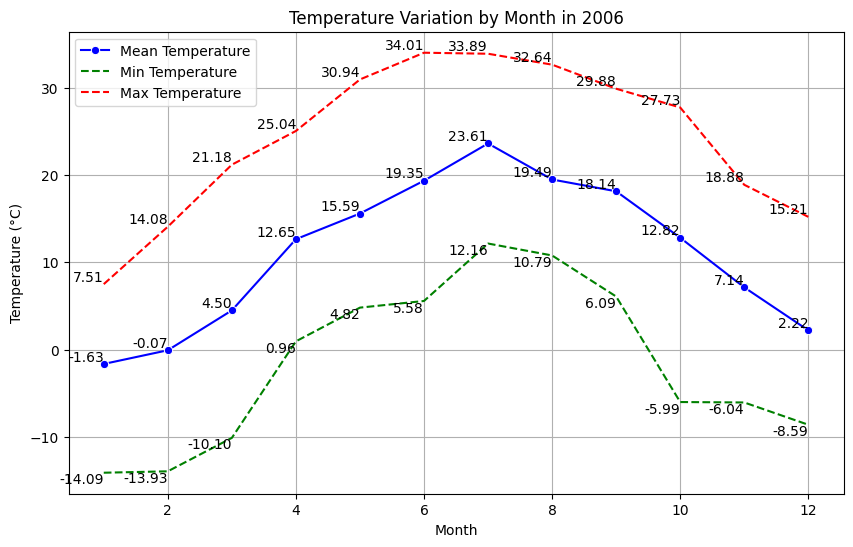


Monthly Statistics for 2006:
    Month  Mean Temperature  Min Temperature  Max Temperature
0       1         -1.634192       -14.088889         7.505556
1       2         -0.065394       -13.927778        14.083333
2       3          4.498375       -10.100000        21.183333
3       4         12.651733         0.955556        25.044444
4       5         15.593954         4.816667        30.944444
5       6         19.351371         5.577778        34.005556
6       7         23.613277        12.155556        33.888889
7       8         19.488588        10.788889        32.638889
8       9         18.138081         6.088889        29.883333
9      10         12.817181        -5.994444        27.733333
10     11          7.137139        -6.044444        18.883333
11     12          2.216779        -8.594444        15.211111



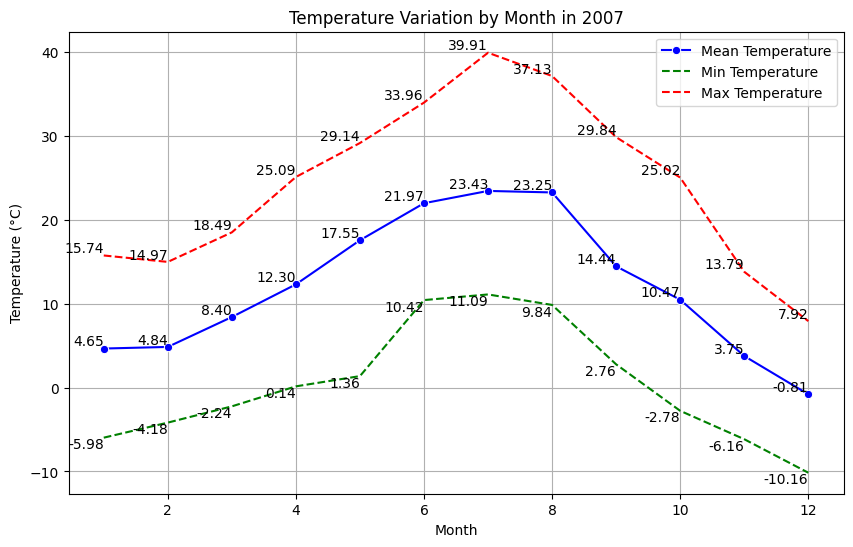


Monthly Statistics for 2007:
    Month  Mean Temperature  Min Temperature  Max Temperature
0       1          4.646019        -5.977778        15.738889
1       2          4.838197        -4.183333        14.972222
2       3          8.403571        -2.244444        18.494444
3       4         12.298223         0.138889        25.094444
4       5         17.554980         1.361111        29.144444
5       6         21.967623        10.422222        33.961111
6       7         23.432799        11.094444        39.905556
7       8         23.252565         9.844444        37.127778
8       9         14.443933         2.761111        29.838889
9      10         10.466271        -2.777778        25.022222
10     11          3.754518        -6.161111        13.794444
11     12         -0.809371       -10.155556         7.916667



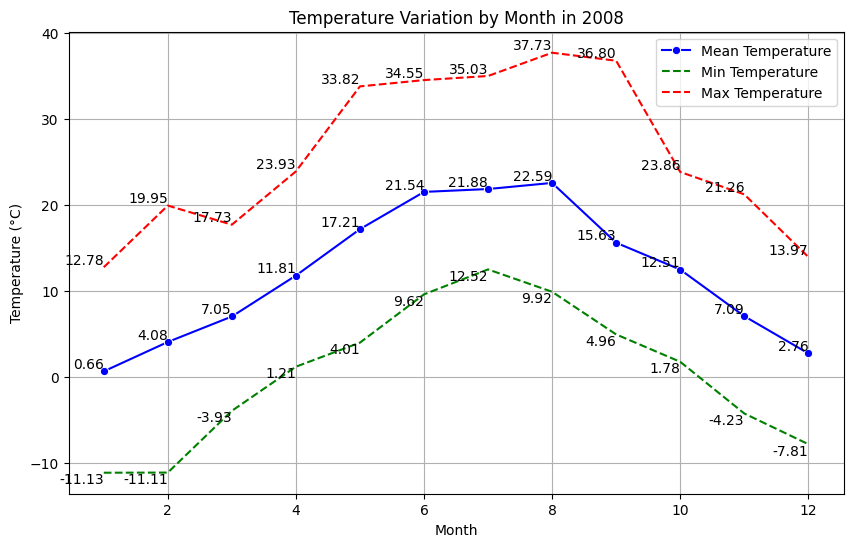


Monthly Statistics for 2008:
    Month  Mean Temperature  Min Temperature  Max Temperature
0       1          0.664754       -11.127778        12.777778
1       2          4.080880       -11.111111        19.950000
2       3          7.046519        -3.927778        17.727778
3       4         11.809528         1.205556        23.927778
4       5         17.209833         4.005556        33.816667
5       6         21.540986         9.622222        34.550000
6       7         21.876107        12.522222        35.027778
7       8         22.587799         9.922222        37.733333
8       9         15.627973         4.961111        36.800000
9      10         12.505342         1.777778        23.861111
10     11          7.089248        -4.233333        21.255556
11     12          2.755820        -7.805556        13.972222



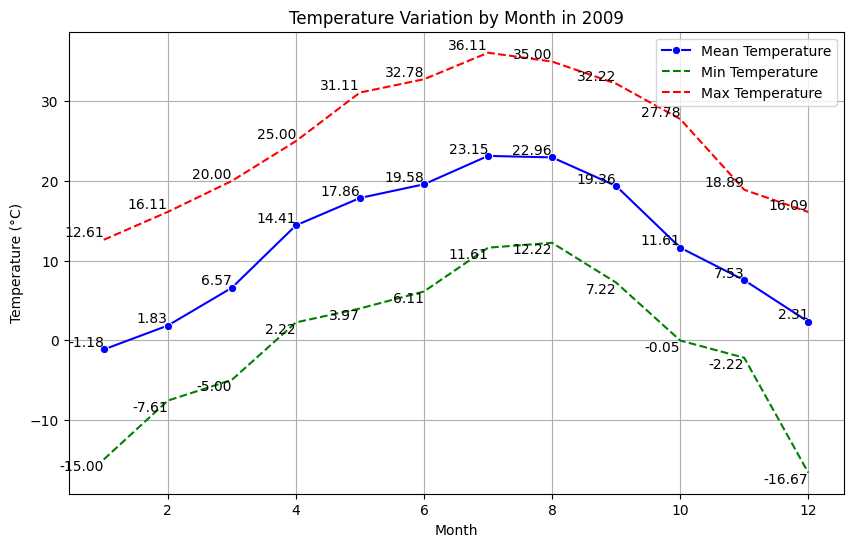


Monthly Statistics for 2009:
    Month  Mean Temperature  Min Temperature  Max Temperature
0       1         -1.179856       -15.000000        12.605556
1       2          1.825205        -7.605556        16.111111
2       3          6.574929        -5.000000        20.000000
3       4         14.414044         2.222222        25.000000
4       5         17.858143         3.972222        31.111111
5       6         19.577794         6.111111        32.777778
6       7         23.145620        11.611111        36.111111
7       8         22.958549        12.222222        35.000000
8       9         19.363472         7.222222        32.222222
9      10         11.610675        -0.050000        27.777778
10     11          7.528075        -2.222222        18.888889
11     12          2.310676       -16.666667        16.094444



In [ ]:
# List to store the years you want to analyze
years = [2006, 2007, 2008, 2009]

# Iterate through each year
for year in years:
    # Filter data for the current year
    year_data = DAdata[DAdata['Year'] == year]

    # Group data by month and calculate mean, min, and max temperature for each month
    monthly_stats = year_data.groupby('Month')['Temperature_(C)'].agg(['mean', 'min', 'max']).reset_index()

    # Plot the relationship between temperature and month
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Month', y='mean', data=monthly_stats, marker='o', color='blue', label='Mean Temperature')
    plt.plot(monthly_stats['Month'], monthly_stats['min'], linestyle='--', color='green', label='Min Temperature')
    plt.plot(monthly_stats['Month'], monthly_stats['max'], linestyle='--', color='red', label='Max Temperature')

    for i, row in monthly_stats.iterrows():
        plt.text(row['Month'], row['mean'], f"{row['mean']:.2f}", ha='right', va='bottom')
        plt.text(row['Month'], row['min'], f"{row['min']:.2f}", ha='right', va='top')
        plt.text(row['Month'], row['max'], f"{row['max']:.2f}", ha='right', va='bottom')

    # Add labels and title
    plt.xlabel('Month')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Temperature Variation by Month in {year}')

    # Show legend
    plt.legend()

    # Show plot
    plt.grid(True)
    plt.show()

    # Generate a table with mean, min, and max temperatures for each month
    monthly_stats_table = monthly_stats.rename(columns={'mean': 'Mean Temperature', 'min': 'Min Temperature', 'max': 'Max Temperature'})
    print(f"\nMonthly Statistics for {year}:\n{monthly_stats_table}\n{'='*50}\n")

# Modeling



---



Labeling the Summary, Daily_Summary and Precip_Type columns from string to integer by using cat.codes because the machine learning model cant process string data.

In [20]:
weather_data.loc[:,'Summary']=(weather_data['Summary'].astype('category')).cat.codes
weather_data.loc[:,'Daily_Summary']=(weather_data['Daily_Summary'].astype('category')).cat.codes
weather_data.loc[:,'Precip_Type']=(weather_data['Precip_Type'].astype('category')).cat.codes

<ipython-input-20-9f59f11b4016>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data.loc[:,'Summary']=(weather_data['Summary'].astype('category')).cat.codes
<ipython-input-20-9f59f11b4016>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  weather_data.loc[:,'Summary']=(weather_data['Summary'].astype('category')).cat.codes
<ipython-input-20-9f59f11b4016>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea



---



## Random Forest Model

In [21]:
WD = pd.DataFrame()

WD["M"]=weather_data["Month"]
WD["Y"]=weather_data["Year"]
WD["D"]=weather_data["Day"]
WD["Hour"]=weather_data["Hour"]
WD["WS"]=weather_data["Wind_Speed_(km/h)"]
WD["WB"]=weather_data["Wind_Bearing_(degrees)"]
WD["Pressure"]=weather_data["Pressure_(millibars)"]
WD["Visibility"]=weather_data["Visibility_(km)"]
WD["Summary"]=weather_data["Summary"]
WD["Daily_Summary"]=weather_data["Daily_Summary"]
WD["PT"]=weather_data["Precip_Type"]
WD["H"]=weather_data["Humidity"]



# Temperature (C) will be the predicted data
temp=weather_data["Temperature_(C)"]

# Split the data to training and testing data
xtrain,xtest,ytrain,ytest = train_test_split(WD,temp,train_size=0.8)


Train Mean Absolute Error (MAE): 0.4088942937269023
Train Root Mean Squared Error (RMSE): 0.5706623506294982
Train R2 Score:  0.9963918585546925


Test Mean Absolute Error (MAE): 1.0794294643281523
Test Root Mean Squared Error (RMSE): 1.4855756789578909
Test R2 Score:  0.9753727809664969


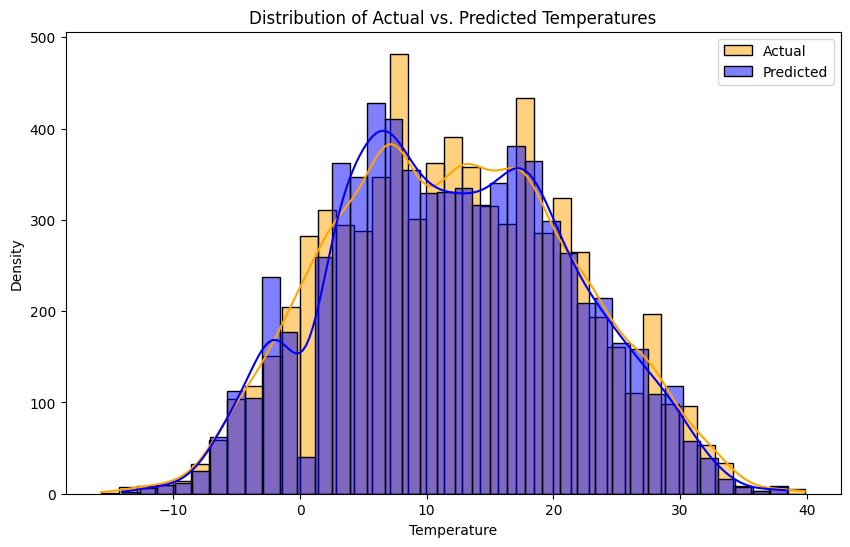

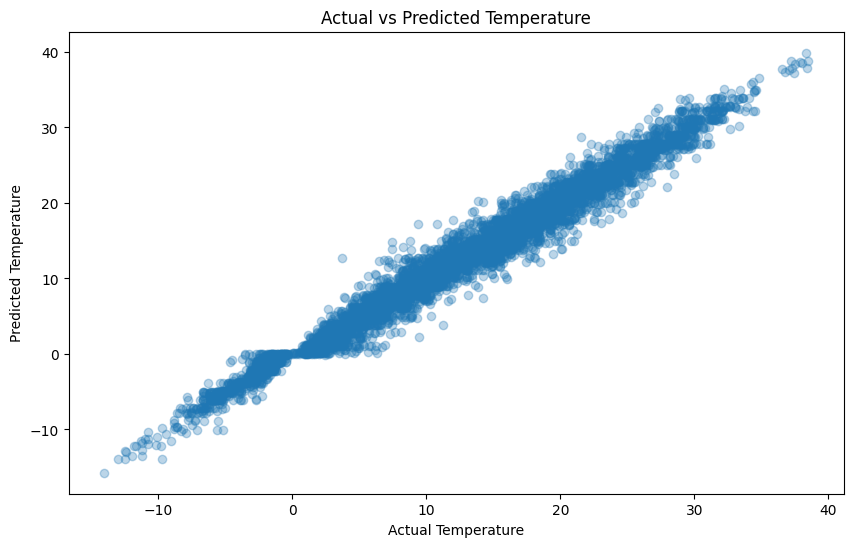

In [22]:
# Create the random forest model
RFmodel=RandomForestRegressor()

# Fit the model
RFmodel.fit(xtrain,ytrain)

# Generate predictions
train_preds = RFmodel.predict(xtrain)
preds=RFmodel.predict(xtest)

# Score the predictions
train_mae = mean_absolute_error(ytrain, train_preds)
train_rmse = mean_squared_error(ytrain, train_preds, squared=False)
train_R2 = r2_score(ytrain, train_preds)
print("\nTrain Mean Absolute Error (MAE):", train_mae)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Train R2 Score: ",train_R2)
print("\n"+'='*40)

test_mae = mean_absolute_error(ytest, preds)
test_rmse = mean_squared_error(ytest, preds, squared=False)
Test_R2 = r2_score(ytest,preds)
print("\nTest Mean Absolute Error (MAE):", test_mae)
print("Test Root Mean Squared Error (RMSE):", test_rmse)
print("Test R2 Score: ",Test_R2)

# Plot a histogram to show the distribution of actual and predicted temperatures
plt.figure(figsize=(10, 6))
sns.histplot(ytest, color='orange', label='Actual', kde=True)
sns.histplot(preds, color='blue', label='Predicted', kde=True)
# Add labels and title
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.title('Distribution of Actual vs. Predicted Temperatures')
# Add legend
plt.legend()
# Show plot
plt.show()

#Count the mean temperature of the predicted data and actual data
mean_predicted_temp = np.mean(preds)
mean_actual_temp = np.mean(ytest)

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y=ytest, x=preds, alpha=0.3)
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Actual vs Predicted Temperature')
plt.show()

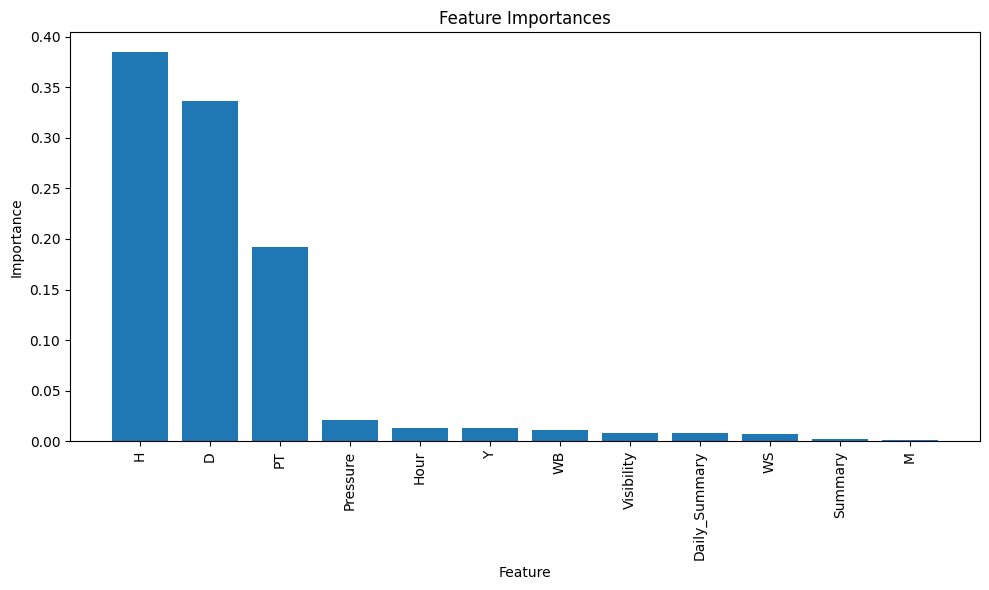

In [23]:
# Get feature importances from the trained random forest model
importances = RFmodel.feature_importances_

# Get the names of the features
feature_names = xtrain.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(xtrain.shape[1]), importances[indices], align="center")
plt.xticks(range(xtrain.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, xtrain.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()